In [83]:
import MySQLdb
import random
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [10]:
def execute_sql(sql):
    conn = None
    try:
        conn = MySQLdb.connect(
            host='localhost' 
            , user='root'
            , passwd='6687453'
            , db='employees'
            , port=3306
        )
        cursor = conn.cursor()
        cursor.execute(sql)
        res = cursor.fetchall()
        return res
    except Exception as e:
        conn.rollback()
        raise e
    else:
        conn.commit()
    finally:
        if conn:
            conn.close()


def GET_CONNECTION():
    conn = MySQLdb.connect(
        host='localhost' 
        , user='root'
        , passwd='6687453'
        , db='employees'
        , port=3306
    )
    return conn


In [97]:
df = pd.read_sql("""
select *
from salaries s
         join (select * from titles where to_date = '9999-01-01') t
              on s.emp_no = t.emp_no
where s.to_date = '9999-01-01'
;
"""
    , GET_CONNECTION()
)
df.head()

,emp_no,salary,from_date,to_date,emp_no,title,from_date,to_date
0,10001,88958,2002-06-22,9999-01-01,10001,Senior Engineer,1986-06-26,9999-01-01
1,10002,72527,2001-08-02,9999-01-01,10002,Staff,1996-08-03,9999-01-01
2,10003,43311,2001-12-01,9999-01-01,10003,Senior Engineer,1995-12-03,9999-01-01
3,10004,74057,2001-11-27,9999-01-01,10004,Senior Engineer,1995-12-01,9999-01-01
4,10005,94692,2001-09-09,9999-01-01,10005,Senior Staff,1996-09-12,9999-01-01


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12741c978>]],
      dtype=object)

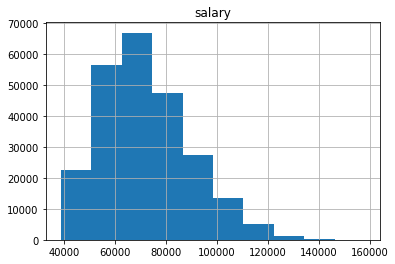

In [28]:
df.hist(column='salary')


##### Figure 1. This figure describe the salary range within all the empoyees. From the figure, within each salary range, around 70000USD has most of the employees.

### Plot salary trend for each employee titles

In [98]:
df_salary = pd.read_sql("""
select s.emp_no
     , s.salary
     , s.from_date
     , t.title
from salaries s
         join titles t
              on s.emp_no = t.emp_no
                  and s.to_date between t.from_date and t.to_date
                  and s.from_date
;
"""
    , GET_CONNECTION()
)
df_salary.head()

,emp_no,salary,from_date,title
0,10001,60117,1986-06-26,Senior Engineer
1,10001,62102,1987-06-26,Senior Engineer
2,10001,66074,1988-06-25,Senior Engineer
3,10001,66596,1989-06-25,Senior Engineer
4,10001,66961,1990-06-25,Senior Engineer


In [99]:
def categorization_method(title):
    if title == "Senior Engineer":
        return 2
    if title == "Staff":
        return 4
    if title == "Engineer":
        return 6
    if title == "Senior Staff":
        return 8
    if title == "Assistant Engineer":
        return 10
    if title == "Technique Leader":
        return 12
    if title == "Manager":
        return 14


df_salary['title_hue'] = df_salary.title.apply(categorization_method)
df_salary.head()

,emp_no,salary,from_date,title,title_hue
0,10001,60117,1986-06-26,Senior Engineer,2
1,10001,62102,1987-06-26,Senior Engineer,2
2,10001,66074,1988-06-25,Senior Engineer,2
3,10001,66596,1989-06-25,Senior Engineer,2
4,10001,66961,1990-06-25,Senior Engineer,2


(array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.]),
 <a list of 7 Text xticklabel objects>)

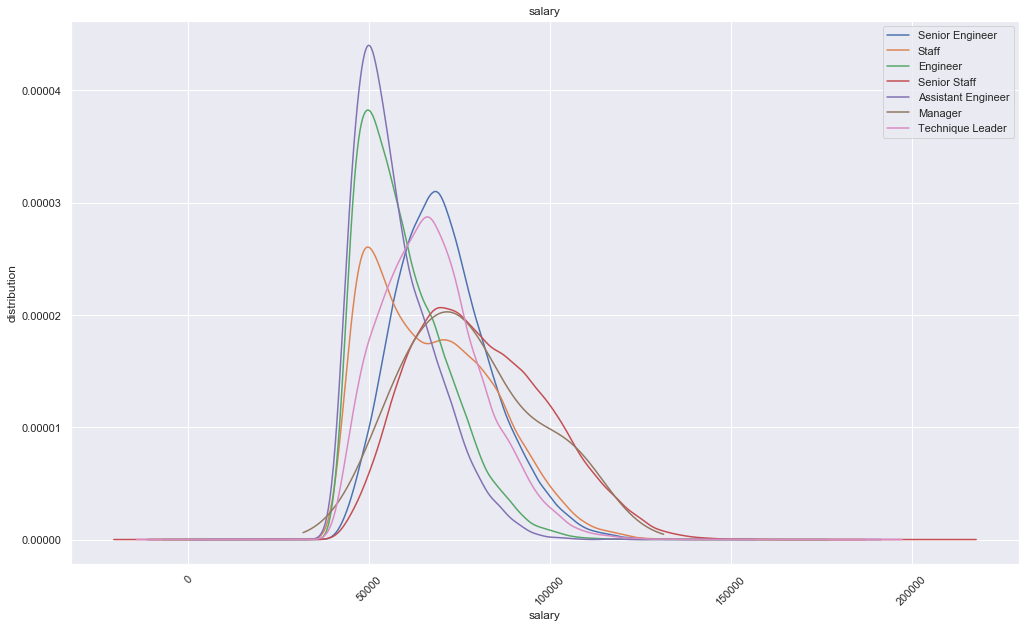

In [100]:
plt.figure(figsize=(17,10))
df[df['title'] == 'Senior Engineer'].salary.plot.kde()
df[df['title'] == 'Staff'].salary.plot.kde()
df[df['title'] == 'Engineer'].salary.plot.kde()
df[df['title'] == 'Senior Staff'].salary.plot.kde()
df[df['title'] == 'Assistant Engineer'].salary.plot.kde()
df[df['title'] == 'Manager'].salary.plot.kde()
df[df['title'] == 'Technique Leader'].salary.plot.kde()
plt.plot()
plt.legend([
    'Senior Engineer'
    , 'Staff'
    , 'Engineer'
    , 'Senior Staff'
    , 'Assistant Engineer'
    , 'Manager'
    , 'Technique Leader'
]
)
plt.xlabel('salary')
plt.ylabel('distribution')
plt.title("salary")
plt.xticks(rotation='45')

#### Figure 2. This figure shows the probability density of the salary for each occupation in the compamy.
 

In [ ]:
### Get current Employee Set, and plot salary histogram
### plot salary trend 
### get the highest salary in each department
### how many employees in each department, and avg salatry for each department 
### In each Department, Who has highest slalary increase.

#### Max Salary for each department

In [146]:
max_salary = pd.read_sql("""
select  d.dept_name,temp.max_sal
from
    (select max(s.salary) max_sal, de.dept_no
     from salaries s join dept_emp de
     on s.emp_no = de.emp_no
     group by de.dept_no) temp
join departments d on
d.dept_no=temp.dept_no
group by temp.dept_no
order by max_sal desc;
"""
    , GET_CONNECTION()
)
max_salary

,dept_name,max_sal
0,Sales,158220
1,Marketing,145128
2,Customer Service,144866
3,Development,144434
4,Finance,142395
5,Human Resources,141953
6,Production,138273
7,Quality Management,132103
8,Research,130211


### The number of manager and the max salary per each department 

In [104]:
manager_salary = pd.read_sql("""
select d.dept_name, count(temp.emp_no) manager_no ,max(temp.salary) max_sal
from
(select s.salary, dm.emp_no, dm.dept_no, s.to_date
from dept_manager dm join salaries s on s.emp_no = dm.emp_no) temp
join departments d on temp.dept_no = d.dept_no
where temp.to_date = '9999-01-01'
group by d.dept_name
order by max_sal desc
"""
    , GET_CONNECTION()
)
manager_salary

,dept_name,manager_no,max_sal
0,Marketing,2,108407
1,Research,2,103244
2,Sales,2,101987
3,Quality Management,4,93193
4,Finance,2,88443
5,Human Resources,2,79229
6,Production,4,75121
7,Development,2,74510
8,Customer Service,4,73953



### Currently how many employees in each department 

In [153]:
df_emp = pd.read_sql("""
Select d.dept_name, count(distinct temp.emp_no) as employee_cnt
from
    (select e.emp_no, e.dept_no
     from dept_emp e
    where e.to_date = '9999-01-01') temp
join departments d on d.dept_no = temp.dept_no
group by d.dept_name
order by employee_cnt desc;
"""
    , GET_CONNECTION()
)
df_emp

,dept_name,employee_cnt
0,Development,61386
1,Production,53304
2,Sales,37701
3,Customer Service,17569
4,Research,15441
5,Marketing,14842
6,Quality Management,14546
7,Human Resources,12898
8,Finance,12437


In [156]:
df_emp.dept_name.unique

<bound method Series.unique of 0           Development
1            Production
2                 Sales
3      Customer Service
4              Research
5             Marketing
6    Quality Management
7       Human Resources
8               Finance
Name: dept_name, dtype: object>

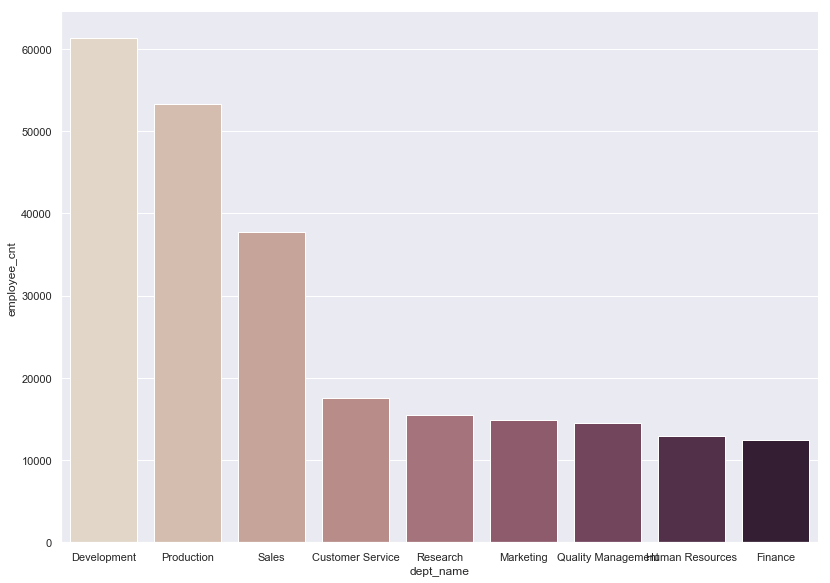

In [143]:
sns.catplot(x="dept_name", y="employee_cnt", kind="bar", palette="ch:.25", data=df_emp, height=8.27, aspect=11.7/8.27);

                  Figure 3. This figure describe the amount of employees in each department.

### display the comparison result (higher/same/lowe) of the average salary of employees in a department to the company's average salary

In [134]:
com_salary = pd.read_sql("""


select d3.dept_name, d3.department_avg,
        case when d3.department_avg > c1.company_avg then "higher"
            when d3.department_avg < c1.company_avg then "lower"
            else "same" end as "comparison"
from
   (select 
        d.dept_name,temp.avg_sal as department_avg,d.dept_no
    from
        (select avg(s.salary) avg_sal, de.dept_no
             from salaries s 
             join dept_emp de on s.emp_no = de.emp_no
             group by de.dept_no) temp
    join departments d on d.dept_no=temp.dept_no
    group by temp.dept_no) d3,
    (select avg(s.salary) as company_avg  from salaries s) c1
order by comparison;
"""
    , GET_CONNECTION()
)
com_salary

,dept_name,department_avg,comparison
0,Sales,80667.6058,higher
1,Finance,70489.3649,higher
2,Marketing,71913.2000,higher
3,Production,59605.4825,lower
4,Quality Management,57251.2719,lower
5,Research,59665.1817,lower
6,Customer Service,58770.3665,lower
7,Development,59478.9012,lower
8,Human Resources,55574.8794,lower


##### From the result table, the "sales", "Finance", and "Marketing" departments avergae salary are higher than the avergae salary of the whole company, which indicate that employees who work in these three department have higher salary than employees from other department on average. 

In [141]:
gender_cnt = pd.read_sql("""
select
    d.dept_name,
    sum(case when e.gender='M' then 1 end)as male_cnt,
    sum(case when e.gender='F' then 1 end)as female_cnt,
    count(e.gender) total_employee
from dept_emp de
join employees e on de.emp_no = e.emp_no
join departments d on de.dept_no = d.dept_no
group by de.dept_no
order by male_cnt desc, female_cnt desc;
"""
    , GET_CONNECTION()
)
gender_cnt

,dept_name,male_cnt,female_cnt,total_employee
0,Development,51449.0,34258.0,85707
1,Production,43936.0,29549.0,73485
2,Sales,31391.0,20854.0,52245
3,Customer Service,14132.0,9448.0,23580
4,Research,12687.0,8439.0,21126
5,Marketing,12174.0,8037.0,20211
6,Quality Management,12039.0,8078.0,20117
7,Human Resources,10711.0,7075.0,17786
8,Finance,10331.0,7015.0,17346


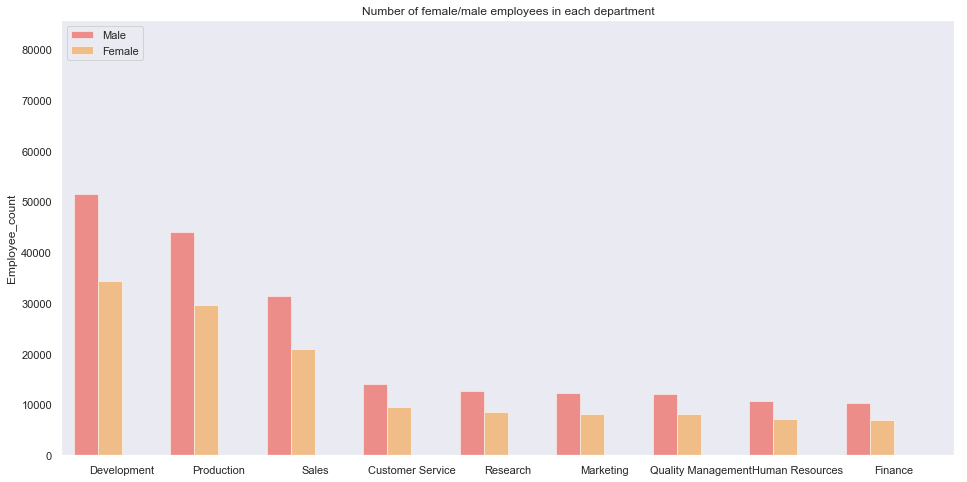

In [162]:
# Setting the positions and width for the bars
pos = list(range(len(gender_cnt['male_cnt']))) 
width = 0.25 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(16,8))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        #using gender_cnt['male_cnt'] data,
        gender_cnt['male_cnt'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#EE3224', 
        # with label the first value in dept_name
        label=gender_cnt['dept_name'][0]) 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], 
        #using gender_cnt['female_cnt'] data,
        gender_cnt['female_cnt'],
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#F78F1E', 
        # with label the second value in dept_name
        label=gender_cnt['dept_name'][1]) 

# Set the y axis label
ax.set_ylabel('Employee_count')

# Set the chart's title
ax.set_title('Number of female/male employees in each department')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(gender_cnt['dept_name'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(gender_cnt['female_cnt'] + gender_cnt['male_cnt'])] )

# Adding the legend and showing the plot
plt.legend(['Male', 'Female'], loc='upper left')
plt.grid()
plt.show()


In [137]:
gender_percent = pd.read_sql("""
select
    d.dept_name,
    100* sum(case when e.gender='M' then 1 end)/count(e.gender) as male_percentage,
    100* sum(case when e.gender='F' then 1 end)/count(e.gender) as female_percentage
from dept_emp de
join employees e on de.emp_no = e.emp_no
join departments d on de.dept_no = d.dept_no
group by de.dept_no;
"""
    , GET_CONNECTION()
)
gender_percent

,dept_name,male_percentage,female_percentage
0,Customer Service,59.9321,40.0679
1,Development,60.0289,39.9711
2,Finance,59.5584,40.4416
3,Human Resources,60.2215,39.7785
4,Marketing,60.2345,39.7655
5,Production,59.7891,40.2109
6,Quality Management,59.8449,40.1551
7,Research,60.0540,39.9460
8,Sales,60.0842,39.9158
